# Preamble
This is a brief introduction to performing some numerical computations utilising the pieces of Julia code delivered with this guide. This guide is available as a PDF file and an interactive Jupyter notebook. 


# On the Julia programming language
This is not a comprehensive guide to the use of the Julia programming language. If the reader is interested in one, I recommend taking a look at the excellent workshop by Dr. Carsten Bauer (http://carstenbauer.eu/#workshops). Assuming the reader is familiar with Python, this guide should be legible and give a fairly good idea of how to write working Julia code. The most important difference to Python is that Julia automatically compiles functions the first time they are called in a piece of code, allowing performance similar to C++ or Fortran.

Once the reader has managed to write some working code, I'd recommend reading the "Gotchas" part (the first file of Day 2) of the above workshop in order to make their code run smoothly. Once the code runs smoothly, I'd recommend taking a look at the Day 3 of the workshop, wherein parallelisation is discussed.

## Setting up Julia
For this section of the guide I'll assume the reader is using a Debian based Linux distribution (e.g. Ubuntu). If memory serves, installing Julia on Windows is trivial using the binaries.

### Step 1: dependencies
These are quite likely already installed, but running the line

`sudo apt install build-essential libatomic1 python gfortran perl wget m4 cmake pkg-config curl`

won't hurt.

### Step 2: Installing Julia

Running the lines 

`git clone https://github.com/julialang/julia`

`cd julia`

`make`

`make install`

will install the newest version of Julia. This will take quite some time.

### Step 3: Installing Julia packages
Most of the pieces of code provided with this guide don't require additional packages. However, we'll be computing the ground states of some systems in the examples in this guide, and we'll be using the KrylovKit package for that.

Julia comes with its own package handling tool, which can be accessed by running the REPL:

`julia`

and typing `]`. Then, KrylovKit can be installed with the command `add KrylovKit`.

Other packages that might be useful are DelimitedFiles, BSON, Combinatorics, Multisets, and Plots. 

DelimitedFiles can be used to save data in text form for e.g. plotting using Python and Matplotlib. 

BSON can be used to save data in the BSON format, unsurprisingly, which can be useful if the data is used again in Julia code. 

Combinatorics and Multisets are necessary for running the Transform.jl code provided with this guide. 

The Plots package can be used for plotting in Julia. It tends to be a bit slow, so I prefer using Matplotlib. I will, however, be using Plots at one point in this guide. If the reader wants that part of the notebook to work interactively, Plots needs to be installed(`]add Plots`).

### Step 4: Installing Jupyter

This step is only necessary if the reader wants to use the interactive Jupyter notebook version of this guide, or is interested in the materials of the previously mentioned workshop. 

On the Julia side we'll need to install the package IJulia (`]add IJulia`). The easiest way to install Jupyter without additional software is via pip:

`pip install notebook`,

after which Jupyter can be accessed by running

`jupyter notebook.` 

# Using the code

This guide comes with five pieces of Julia code: Basis.jl, Operators.jl, Time.jl, Transform.jl, and Density.jl. In the rest of the guide we'll discuss some of the contents of these codes, and provide some examples for performing simple numerical computations using them.


## The basis

When doing numerical linear algebra, it is important to be sure that all vectors and matrices are represented in the same basis and in the same order. The Hilbert space of bosonic lattice model with $L$ sites, and a fixed number of bosons $N$ has the dimension

$d = \binom{L + N - 1}{N}.$

Fortunately, there is a simple formula for assigning unique indices running from 1 to $d$ for a set of basis vectors, as detailed in A. I. Streltsov et al, Phys. Rev. A 81, 022124 (2010). There is also a simple algorithm for iterating through the basis in that order, but I've unfortunately lost the reference for that.

Let us, for example, take a small system with $L = 4, N = 2$, and look at its basis. We'll start by computing the Hilbert space `dimension`:

In [1]:
include("Basis.jl"); #this imports the functions from Basis.jl
L = 4
N = 2
d = dimension(L, N)

10

In our indexing system, the first basis vector is the one with all bosons on the first site. In this example $| 2 0 0 0 \rangle$. We can find the index of a specific basis vector using the function `find_index`: 

In [2]:
find_index([2, 0, 0, 0])

1

In [3]:
find_index([0, 1, 1, 0])

6

The function `next!` changes a basis vector for the next one in order:

In [4]:
basis_vector = [2, 0, 0, 0]
println(find_index(basis_vector), " ", basis_vector)
for i in 1:d 
    next!(basis_vector)
    println(find_index(basis_vector), " ", basis_vector)
end

1 [2, 0, 0, 0]
2 [1, 1, 0, 0]
3 [1, 0, 1, 0]
4 [1, 0, 0, 1]
5 [0, 2, 0, 0]
6 [0, 1, 1, 0]
7 [0, 1, 0, 1]
8 [0, 0, 2, 0]
9 [0, 0, 1, 1]
10 [0, 0, 0, 2]
1 [2, 0, 0, 0]


Note that `next!` loops back to the first vector after it has reached the $d$th vector. Here I've used the Julia convention of noting an in-place function with an exclamation point:

In [5]:
using LinearAlgebra #this line imports the built-in linear algebra package
vector = rand(2)
normalize!(vector)
println(vector, ", ", norm(vector), "\n")

vector = rand(2)
vector2 = normalize(vector) 
println(vector, ", ", norm(vector))
println(vector2, ", ", norm(vector2))

[0.11572593115699752, 0.9932811831791871], 1.0

[0.775757526125693, 0.9745002505715814], 1.2455723494461213
[0.6228120963592805, 0.7823714543799245], 1.0


## Operators

Now that we have a basis to work with, we can construct some operators and state vectors to operate on. Let us, as an example, write a function that returns the operator $a^\dagger_{\ell+1} a_{\ell}$:

In [6]:
using LinearAlgebra, SparseArrays #import some built-in packages
include("Basis.jl")

function example_hop(L, N, l)
    d = dimension(L, N)
    hop = spzeros(d, d) #create a d x d sparse matrix
    basis_vector = zeros(Int64, L) #create a L-component vector of integers; default is Float64
    basis_vector[1] = N 
    for i in 1:d
        if i != 1
            next!(basis_vector)
        end
        
        if basis_vector[l] > 0 
            modified_vector = copy(basis_vector)
            modified_vector[l] -= 1
            modified_vector[l + 1] += 1
            index = find_index(modified_vector)
            hop[index, i] = sqrt(basis_vector[l] * modified_vector[l + 1])
        end
    end
    
    return hop
end

example_hop (generic function with 1 method)

Now let's check that it does what we want it to do. We'll do this by initialising the vector $|0 2 0 0\rangle$ in the full Hilbert space and operating on it with $O = a^\dagger_3 a_2$: 

In [7]:
L = 4; N = 2; d = dimension(L, N)
state_vector = zeros(d)
state_vector[find_index([0, 2, 0, 0])] = 1.
O = example_hop(L, N, 2)
print_state(L, N, state_vector) #this is a function from Basis.jl

state_vector .= O * state_vector
print_state(L, N, state_vector)

state_vector .= O * state_vector
print_state(L, N, state_vector)

state_vector .= O' * state_vector #here ' denotes the adjoint
print_state(L, N, state_vector)

state_vector .= example_hop(L, N, 1)' * state_vector
print_state(L, N, state_vector)


1.0 |0200⟩         1.0

1.4142 |0110⟩         2.0

2.0 |0020⟩         4.0

2.8284 |0110⟩         8.0

2.8284 |1010⟩         8.0



The file Operators.jl contains a selection of functions for creating operators. Below are some examples, starting with the number operators $n_\ell$:

In [8]:
include("Operators.jl")
L = 4; N = 2; d = dimension(L, N)
state_vector = zeros(d)
state_vector[find_index([0, 2, 0, 0])] = 1.

n2 = number(L, N, 2)
println(state_vector' * n2 * state_vector)

ns = numbers(L, N)
println(state_vector' * ns[2] * state_vector)
println(state_vector' * ns[1] * state_vector)

2.0
2.0
0.0


The terms of the one-dimensional Bose–Hubbard Hamiltonian 

$H = H_U + H_J,$

where

$H_U = -\frac{U}{2}\sum_\ell n_\ell (n_\ell - 1),$

and

$H_J = J \sum_\ell (a^\dagger_\ell a_{\ell + 1} + \text{H.c.}),$

can be constructed separately, with the functions:

In [9]:
HU = interaction(L, N);
HJ = hopping(L, N, periodic = false);

Note that these don't include the parameters $U$ and $J$. We get the total Hamiltonian with e.g. $U = 1, J = 0.5$ by taking the sum:

In [10]:
J = 0.5
H = HU .+ J .* HJ #here the . denote componentwise operations

10×10 SparseMatrixCSC{Float64, Int64} with 28 stored entries:
 -1.0       0.707107   ⋅    ⋅   …   ⋅     ⋅         ⋅          ⋅ 
  0.707107   ⋅        0.5   ⋅       ⋅     ⋅         ⋅          ⋅ 
   ⋅        0.5        ⋅   0.5      ⋅     ⋅         ⋅          ⋅ 
   ⋅         ⋅        0.5   ⋅      0.5    ⋅         ⋅          ⋅ 
   ⋅        0.707107   ⋅    ⋅       ⋅     ⋅         ⋅          ⋅ 
   ⋅         ⋅        0.5   ⋅   …  0.5   0.707107   ⋅          ⋅ 
   ⋅         ⋅         ⋅   0.5      ⋅     ⋅        0.5         ⋅ 
   ⋅         ⋅         ⋅    ⋅       ⋅   -1.0       0.707107    ⋅ 
   ⋅         ⋅         ⋅    ⋅      0.5   0.707107   ⋅         0.707107
   ⋅         ⋅         ⋅    ⋅       ⋅     ⋅        0.707107  -1.0

Both terms can be generated with a single function:

In [11]:
HU, HJ = split_hamiltonian(L, N, periodic = false);

There is also a function for generating the Hamiltonian of a rectangular $L_1 \times L_2$ array:

In [12]:
L1 = 3; L2 = 3;
HU, HJ = split_hamiltonian_2D(L1, L2, N, periodic = 0)
display(HJ)
HU, HJ = split_hamiltonian(L1 * L2, N)
display(HJ)
#periodic = 0 for open boundaries
#periodic = 1 for one periodic boundary on the L1 axis, I think
#periodic = 2 for both boundaries periodic

45×45 SparseMatrixCSC{Float64, Int64} with 216 stored entries:
⡪⠊⡢⡀⠐⢔⠀⠀⠀⠄⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠈⠪⡊⡨⡂⠀⠑⢄⠀⠀⠀⠀⠈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀
⢐⢄⠈⠈⠠⠂⡢⡀⠡⡠⠀⠀⢀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠑⢄⠈⠪⡊⡨⡂⠈⠢⡀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀
⠀⠄⠀⠀⠁⡢⡈⠈⠀⡠⡢⡈⠀⠄⠀⢀⠀⠁⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠈⠢⡈⠪⡠⡪⠀⠀⠀⠀⠀⠈⠢⡀⠀⠀⠀
⠀⠈⠢⡀⠀⠐⠀⠀⠀⠄⠀⠀⡪⠊⡢⠢⡂⠀⠄⢀⠀⠀⠀
⠀⠀⠀⠈⠂⠀⢄⠀⠀⢀⠀⠀⠨⡊⠊⡠⠨⣂⢀⠀⠑⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠑⠄⠀⡀⠀⠈⠈⠢⢢⠪⠂⠑⡄⠁⠢⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⠀⢁⠀⠐⠑⠤⠪⠂⡈⠐⠄
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⠀⠡⡀⢂⠈⢎⡱⡀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠈⠀

45×45 SparseMatrixCSC{Float64, Int64} with 144 stored entries:
⠪⡢⡀⠀⠐⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠪⡢⡀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠐⢄⠀⠈⠠⡢⡀⠀⠡⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠑⢄⠀⠈⠪⡢⡀⠈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠁⠢⡀⠈⠠⡢⡀⠈⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠈⠢⡀⠈⠪⡢⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠪⡢⡀⠢⡀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⠠⡈⠊⡠⡈⢂⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⢈⠪⠂⡑⠄⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⠌⡪⠊⡢⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠊⢎⡱⡀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀

A random disorder term

$H_D = \sum_\ell \omega_\ell n_\ell$,   $\omega_\ell \in [-1, 1]$

can be generated as follows:

In [13]:
HD = disorder(L, N)

10×10 SparseMatrixCSC{Float64, Int64} with 10 stored entries:
 1.15431    ⋅         ⋅         ⋅        …    ⋅           ⋅          ⋅ 
  ⋅       -0.071674   ⋅         ⋅             ⋅           ⋅          ⋅ 
  ⋅         ⋅        0.532298   ⋅             ⋅           ⋅          ⋅ 
  ⋅         ⋅         ⋅        0.288604       ⋅           ⋅          ⋅ 
  ⋅         ⋅         ⋅         ⋅             ⋅           ⋅          ⋅ 
  ⋅         ⋅         ⋅         ⋅        …    ⋅           ⋅          ⋅ 
  ⋅         ⋅         ⋅         ⋅             ⋅           ⋅          ⋅ 
  ⋅         ⋅         ⋅         ⋅           -0.0897128    ⋅          ⋅ 
  ⋅         ⋅         ⋅         ⋅             ⋅         -0.333407    ⋅ 
  ⋅         ⋅         ⋅         ⋅             ⋅           ⋅        -0.577102

A specific disorder pattern can also be used:

In [14]:
pattern = ones(L)
for l in 2:L
    pattern[l] = -pattern[l - 1]
end

HD = disorder(L, N, dis = pattern)

10×10 SparseMatrixCSC{Float64, Int64} with 10 stored entries:
 2.0   ⋅    ⋅    ⋅     ⋅    ⋅     ⋅    ⋅    ⋅     ⋅ 
  ⋅   0.0   ⋅    ⋅     ⋅    ⋅     ⋅    ⋅    ⋅     ⋅ 
  ⋅    ⋅   2.0   ⋅     ⋅    ⋅     ⋅    ⋅    ⋅     ⋅ 
  ⋅    ⋅    ⋅   0.0    ⋅    ⋅     ⋅    ⋅    ⋅     ⋅ 
  ⋅    ⋅    ⋅    ⋅   -2.0   ⋅     ⋅    ⋅    ⋅     ⋅ 
  ⋅    ⋅    ⋅    ⋅     ⋅   0.0    ⋅    ⋅    ⋅     ⋅ 
  ⋅    ⋅    ⋅    ⋅     ⋅    ⋅   -2.0   ⋅    ⋅     ⋅ 
  ⋅    ⋅    ⋅    ⋅     ⋅    ⋅     ⋅   2.0   ⋅     ⋅ 
  ⋅    ⋅    ⋅    ⋅     ⋅    ⋅     ⋅    ⋅   0.0    ⋅ 
  ⋅    ⋅    ⋅    ⋅     ⋅    ⋅     ⋅    ⋅    ⋅   -2.0

## Eigensolvers

The built-in LinearAlgebra package contains eigensolvers for the full spectra of dense matrices:

In [15]:
using LinearAlgebra, SparseArrays
include.(["Operators.jl", "Basis.jl"]) #adding the . to any function allows it to be applied to an array of inputs
L = 4; N = 3;
HU, HJ = split_hamiltonian(L, N)
H = Matrix(HU .+ 0.05 .* HJ) #convert the Hamiltonian into a dense matrix
out = eigen(H)
println("ground state energy E = ", out.values[1], "\nground state:")
print_state(L, N, out.vectors[:, 1],  0.9999)

ground state energy E = -3.0077012489315673
ground state:
-0.7049 |0300⟩         0.4969
0.7049 |0030⟩         0.9938
0.0334 |3000⟩         0.9949
-0.0334 |0003⟩         0.996
0.0321 |0210⟩         0.9971
-0.0321 |0120⟩         0.9981
0.0306 |1200⟩         0.999
-0.0306 |0021⟩         1.0



If there is no need to compute the full eigendecomposition, we can use e.g. KrylovKit for specific eigenpairs:

In [16]:
using LinearAlgebra, SparseArrays, KrylovKit
include.(["Operators.jl", "Basis.jl", "Density.jl"])
L = 4; N = 3;
HU, HJ = split_hamiltonian(L, N)
H = HU .+ 0.05 .* HJ #keep the matrix sparse
vals, vecs, info = eigsolve(H, 1, :SR) # 1 to compute a single eigenpair, :SR for smallest real eigenvalue,
println("ground state energy E = ", vals[1], "\nground state:")
print_state(L, N, vecs[1],  0.9999)

ground state energy E = -3.0077012489315678
ground state:
0.7049 |0030⟩         0.4969
-0.7049 |0300⟩         0.9938
-0.0334 |0003⟩         0.9949
0.0334 |3000⟩         0.996
-0.0321 |0120⟩         0.9971
0.0321 |0210⟩         0.9981
-0.0306 |0021⟩         0.999
0.0306 |1200⟩         1.0



## Time-evolution
The uncommented part of the Time.jl code includes some functions for performing time-evolution using a simple Krylov subspace method. Below is a brief demonstration on how it works.

We'll set $L = 5, N = 3, J = 2 U = 1$ and start with the initial state $|30000\rangle$ :

In [17]:
include.(["Operators.jl", "Time.jl"])
L = 5; N = 3;
HU, HJ = split_hamiltonian(L, N)
H = 0.5 .* HU .+ HJ

basis_vector = zeros(Int64, L)
basis_vector[1] = N

state = zeros(dimension(L, N))
state[find_index(basis_vector)] = 1.;

We'll set the time-step to 0.1 and the Krylov subspace dimension to 10, and evolve for 100 time-steps. At every time-step, we'll save the density profile of the state using the `density_profile` function found in the Density.jl file.

In [18]:
include("Density.jl")
dt = 0.1; sdim = 10; steps = 100;
out = zeros(L, steps + 1)
out[:, 1] .= density_profile(L, N, state)
for i in 1:steps
    state = propagate(H, state, sdim, dt)
    out[:, i + 1] .= density_profile(L, N, state)
end

To see what happened to the density profile during that time, we'll plot the density profile as a function of time using the Plots package.

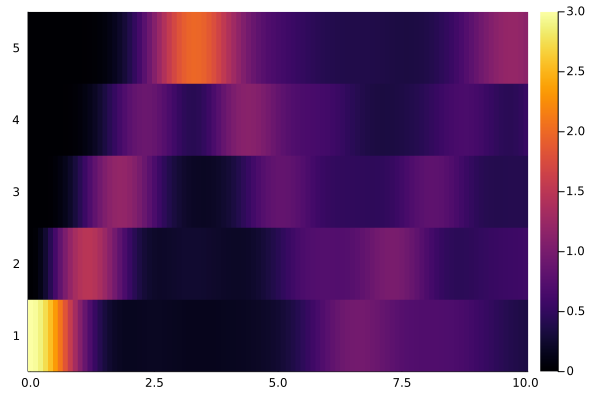

In [19]:
using Plots
time = collect(range(0, 10, length = steps + 1))
sites = collect(range(1, L, length = L))
heatmap!(time, sites, out)

## Reciprocal basis

The Transform.jl code contains functions for the transformations to the reciprocal spaces, i.e. the eigenbases of the hopping terms of the open and periodic Bose–Hubbard models in one dimension. Let's repeat the time-evolution bit from above, but plot the density profile in the reciprocal space this time.

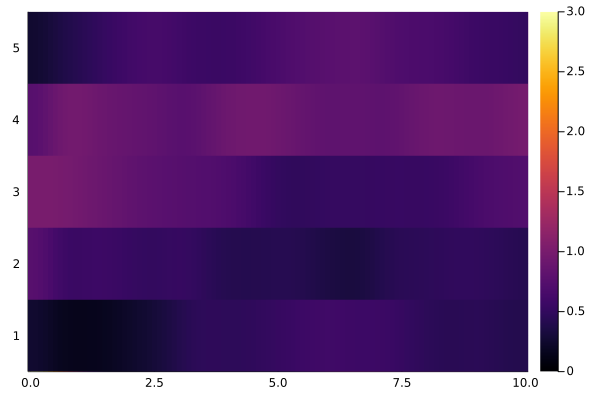

In [20]:
include.(["Operators.jl", "Time.jl", "Transform.jl", "Density.jl"])
using Plots
L = 5; N = 3;
HU, HJ = split_hamiltonian(L, N, periodic = false)
H = 0.5 .* HU .+ HJ

basis_vector = zeros(Int64, L)
basis_vector[1] = N

state = zeros(dimension(L, N))
state[find_index(basis_vector)] = 1.;

T = transform(L, N, periodic = false)

dt = 0.1; sdim = 10; steps = 100;
out = zeros(L, steps + 1)
out[:, 1] .= density_profile(L, N, T * state)
for i in 1:steps
    state = propagate(H, state, sdim, dt)
    out[:, i + 1] .= density_profile(L, N, T * state)
end

time = collect(range(0, 10, length = steps + 1))
sites = collect(range(1, L, length = L))
heatmap!(time, sites, out)

Doesn't look very informative. Anyway, the way the function `transform` is written, it gets really slow with larger $N$. If there is use for that sort of transformations, I recommend saving the matrices in order to avoid having to compute them multiple times.  

## On the Krylov subspace method for time-evolution

The time-evolution of a state under the time-independent Hamiltonian $H$, is given by

$|\psi(t + \delta t)\rangle = e^{-i \delta t H} |\psi(t)\rangle$

We could compute this in Julia simply as

`psi .= exp(-im * dt * H) * psi`.

On a side note, time-evolution via full diagonalisation has its uses, but this is definitely not how to do it efficiently.

By default, the built-in function `exp` computes the exponentials of Hermitian matrices via full diagonalisation, if I remember correctly. Actually, let's check: 

In [21]:
?exp

search: exp exp2 Expr expm1 exp10 export expand! exponent expanduser



```
exp(x)
```

Compute the natural base exponential of `x`, in other words $e^x$.

# Examples

```jldoctest
julia> exp(1.0)
2.718281828459045
```

---

```
exp(A::AbstractMatrix)
```

Compute the matrix exponential of `A`, defined by

$$
e^A = \sum_{n=0}^{\infty} \frac{A^n}{n!}.
$$

For symmetric or Hermitian `A`, an eigendecomposition ([`eigen`](@ref)) is used, otherwise the scaling and squaring algorithm (see [^H05]) is chosen.

[^H05]: Nicholas J. Higham, "The squaring and scaling method for the matrix exponential revisited", SIAM Journal on Matrix Analysis and Applications, 26(4), 2005, 1179-1193. [doi:10.1137/090768539](https://doi.org/10.1137/090768539)

# Examples

```jldoctest
julia> A = Matrix(1.0I, 2, 2)
2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

julia> exp(A)
2×2 Matrix{Float64}:
 2.71828  0.0
 0.0      2.71828
```


Yep. That `?function` thing works for any documented function, by the way. Unfortunately, none of the functions in the code snippets included with this guide are thusly documented.

Anyway, fully diagonalising matrices is slow. Instead, we'll diagonalise the Hamiltonian in a subspace "near" the state $|\psi(t)\rangle$:

$\mathcal{K} = \text{span}\{|\psi(t)\rangle, H |\psi(t)\rangle, H^2 |\psi(t)\rangle, ...\}$.

If this Krylov subspace is orthogonalised, projecting the Hamiltonian to the subspace results in a quickly diagonalisable tridiagonal Hermitian matrix. Both the vectors of the subspace, and the projected Hamiltonian can be easily generated with the well known Lanczos algoritm. I'll not go into more detail about the algorithm, but it is implemented in the Time.jl code:

In [22]:
include("Time.jl")
HU, HJ = split_hamiltonian(L, N)
H = HU .+ 0.5 .* HJ

basis_vector = zeros(Int64, L)
basis_vector[1] = N

state = zeros(dimension(L, N))
state[find_index(basis_vector)] = 1.;

sdim = 5
V, h = lanczos(H, state, sdim) #sdim is the dimension of the Krylov subspace
display(round.(h, digits = 4))


5×5 Matrix{ComplexF64}:
  -3.0+0.0im  0.866+0.0im    0.0+0.0im      0.0+0.0im      0.0+0.0im
 0.866+0.0im   -1.0+0.0im  1.118+0.0im      0.0+0.0im      0.0+0.0im
   0.0+0.0im  1.118+0.0im   -1.0+0.0im    1.245+0.0im      0.0+0.0im
   0.0+0.0im    0.0+0.0im  1.245+0.0im  -1.1935+0.0im   1.9534+0.0im
   0.0+0.0im    0.0+0.0im    0.0+0.0im   1.9534+0.0im  -1.2231+0.0im

By default, the function `propagate` discussed above calls the function `lanczos` and computes the approximate state $|\psi(t + \delta t) \rangle$. In fact, since the function is so short, I might as well copy it here: 

In [23]:
function propagate(H, state, sdim::Int64, dt; algo = lanczos, normalise = true)
    V, h = algo(H, state, sdim)
    if normalise == true
        return normalize(V * exp(-im * dt * h)[1, :]) #If sdim is large enough, normalisation isn't necessary.
    else                                              #It does help with accumulating numerical errors, however.
        return V * (exp(-im * dt * h)[1, :])          #It might be a good idea to normalise now and then if
    end                                               #the time-evolution is long.
end

propagate (generic function with 2 methods)

Basically, we compute a set of $d_s = \text{dim} \mathcal{K}$ weights $\{c_i\}$, given by the first row of the exponential of the projected Hamiltonian, and use them to compute the time-evolved state as

$| \psi(t + \delta t) \rangle = \sum_{i=1}^{d_s} c_i H^{i - 1} |\psi(t)\rangle.$

In principle, a time-independent Hamiltonian projected onto the Krylov subspace remains constant during time-evolution, and needs to be computed only once. This is also implemented in the Time.jl code: one can call

`prop = propagator(H, state, sdim, dt)`

to get the first row of the exponential of the Hamiltonian, and use it for somewhat faster time evolution with

`state = propagate(H, state, prop)`.

However, this seems to be numerically unstable, and I wouldn't recommend using it. 

## Choosing the Krylov subspace dimension

Basically, the dimension $d_s$ (or `sdim`) of the subspace must be chosen so that the state $|\psi(t + \delta t)\rangle$ lies entirely inside the subspace generated around the state $|\psi(t)\rangle$. What that means depends on the Hamiltonian and the length of the time-step $\delta t$ (or `dt`). Usually `sdim = 10` is enough if `dt < 0.5`.

We can use the function `propagator` to estimate a good combination of time-step length `dt` and subspace dimension `sdim` for a given Hamiltonian `H` as follows:

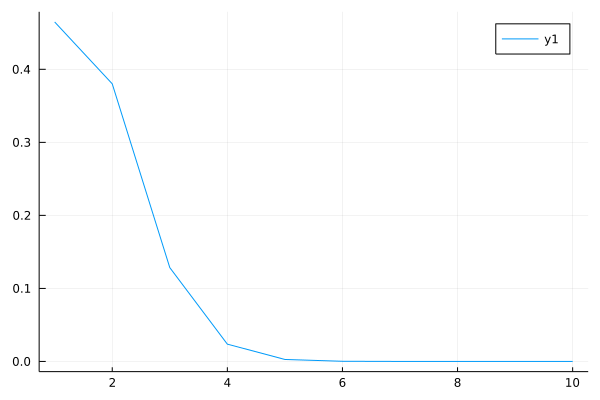

In [24]:
include.(["Operators.jl", "Time.jl"])
using Plots
L = 5; N = 3;
HU, HJ = split_hamiltonian(L, N)
H = HU .* 0.05 .+ HJ

basis_vector = zeros(Int64, L)
basis_vector[1] = N

state = zeros(dimension(L, N))
state[find_index(basis_vector)] = 1.;

sdim = 10; dt = 0.5;

prop = propagator(H, state, sdim, dt)
pic = plot(abs2.(prop))
display(pic)

What this shows is that the weights $c_i$, $i > 5$ are very close to zero. It is generally good to have a subspace a bit larger than strictly necessary in order to minimise numerical errors. Note that while the Krylov subspace method is technically approximate, with properly chosen `sdim` and `dt`, it is accurate up to machine precision. 

## Some other, possibly useful stuff
### Saving things to files

There are two packages I regularly use for saving stuff: DelimitedFiles and BSON. DelimitedFiles saves data in plain text format, meaning it will be easily readable by basically any other software, whereas BSON can be used to save Julia objects in the BSON, or the binary JSON format. Below is a quick example in how to use the packages.


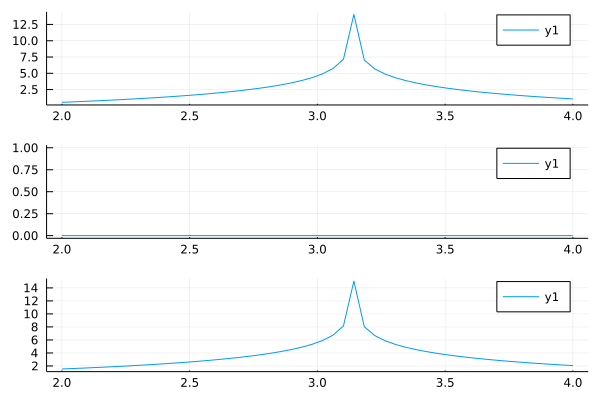

In [25]:
using DelimitedFiles, Plots
using BSON: @save, @load #this line imports only the @save and @load macros from the BSON package

x = collect(range(2., 4., length = 50))
data = -log.(cos.(x) .+ 1)

writedlm("filename", data)
data2 = readdlm("filename")

p1 = plot(x, data2)
@save "filename2" data #note that BSON saves the name of the variable as well
data .*= 0.
p2 = plot(x, data)
@load "filename2" data #meaning that you need to load the variable using the same name
p3 = plot(x, data .+ 1.)

plot(p1, p2, p3, layout = (3, 1))

### The `@time` macro

Sometimes it's nice to know how long something takes to compute. The simplest way to find out is the `@time` macro. Let us, as an example, see how long it takes to fully diagonalise a hamiltonian and compare it to just computing the ground state using KrylovKit: 

In [26]:
using LinearAlgebra, SparseArrays, KrylovKit
include.(["Operators.jl", "Basis.jl"]) 
L = 10; N = 5;
HU, HJ = split_hamiltonian(L, N)
H = HU .+ 0.05 .* HJ
@time out = eigen(Matrix(H))
@time vals, vecs, info = eigsolve(H, 1, :SR);

  1.829440 seconds (17 allocations: 123.034 MiB, 1.05% gc time)
  0.067771 seconds (66.27 k allocations: 8.547 MiB, 88.74% compilation time)
